In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading data
data = pd.read_csv("/content/drive/MyDrive/AML_category_identification/USvideos.csv") #40949 × 16 
data

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,BZt0qjTWNhw,18.14.06,The Cat Who Caught the Laser,AaronsAnimals,15,2018-05-18T13:00:04.000Z,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",1685609,38160,1385,2657,https://i.ytimg.com/vi/BZt0qjTWNhw/default.jpg,False,False,False,The Cat Who Caught the Laser - Aaron's Animals
40945,1h7KV2sjUWY,18.14.06,True Facts : Ant Mutualism,zefrank1,22,2018-05-18T01:00:06.000Z,[none],1064798,60008,382,3936,https://i.ytimg.com/vi/1h7KV2sjUWY/default.jpg,False,False,False,NaN
40946,D6Oy4LfoqsU,18.14.06,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,24,2018-05-18T17:34:22.000Z,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,3992,https://i.ytimg.com/vi/D6Oy4LfoqsU/default.jpg,False,False,False,I had so much fun transforming Safiyas hair in...
40947,oV0zkMe1K8s,18.14.06,How Black Panther Should Have Ended,How It Should Have Ended,1,2018-05-17T17:00:04.000Z,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,13088,https://i.ytimg.com/vi/oV0zkMe1K8s/default.jpg,False,False,False,How Black Panther Should Have EndedWatch More ...


### **Preprocessing Performed**

Video ID: Label Encoding 

Trending_Date: Make new columns "day", "month", "year" 

Title: use top 50 words and see if each video has it 

Channel_title: Label Encoding 

Publish time: Adding column of "published quarters" and Label Encoding 

Tags: Label Encoding 

Views: Sector grouping 

Likes: Sector grouping

Dislikes: Sector grouping

Comments: Sector grouping

Comments Disabled: Label Encoding

Ratings Disabled: Label Encoding

Video Error or Removed: Label Encoding

Thumbnail_link: Drop

Description: Label Encoding




In [ ]:
# outputing json file details
with open('/content/drive/MyDrive/AML_category_identification/US_category_id.json') as f:
  jj = json.load(f)

category_data = {}
for item in jj['items']:
  category_data[int(item['id'])] = item['snippet']['title']
category_data

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 29: 'Nonprofits & Activism',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In [ ]:
# defining functions to use for preprocessing
def my_label_encoding(original_feature , new_feature) :
    '''Performs label encoding on old feature from dataset and assigns it as a new feature. Drops the old feature.
        
        Parameters
        ----------
        original_feature: name of original feature
        new_feature: name of new feature
        
        Returns
        -------
        None
        ''' 
    enc  = LabelEncoder()
    enc.fit(data[original_feature])
    data[new_feature] = enc.transform(data[original_feature])
    data.drop([original_feature],axis=1, inplace=True)

def my_countplot(feature) :
    '''Plotting category distribution on a countplot for a specific feature.
        
        Parameters
        ----------
        feature : name of the feature
        
        Returns
        -------
        None
        '''
    sns.countplot(x=feature, data=data,facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("prism", 5)) 

In [ ]:
# checking unique values for each feature to determine which preprocessing method to take
for items in data.columns : 
    print('Unique values in "{0}": {1}'.format(items ,len(data[items].unique())))

Unique values in "video_id": 6351
Unique values in "trending_date": 205
Unique values in "title": 6455
Unique values in "channel_title": 2207
Unique values in "category_id": 16
Unique values in "publish_time": 6269
Unique values in "tags": 6055
Unique values in "views": 40478
Unique values in "likes": 29850
Unique values in "dislikes": 8516
Unique values in "comment_count": 13773
Unique values in "thumbnail_link": 6352
Unique values in "comments_disabled": 2
Unique values in "ratings_disabled": 2
Unique values in "video_error_or_removed": 2
Unique values in "description": 6902


**Video ID**

In [ ]:
# label encoding
my_label_encoding('video_id', 'video_id_enc')

**Trending Date**

In [ ]:
# dividing into unique year, month, day
year_list = [] #17, 18
month_list = [] #01, 02, 03, 04, 05, 06, 11, 12
day_list = [] #01 - 31

for x in range(data.shape[0]) :
    year_list.append(data['trending_date'][x][:2])
    month_list.append(data['trending_date'][x][6:])
    day_list.append(data['trending_date'][x][3:5])

# adding columns to the data
data.insert(16,'Year',year_list)
data.insert(17,'Month',month_list)
data.insert(18,'Day',day_list)

In [ ]:
# year encoding and deleting "trending_date" column
data.drop(['trending_date'],axis=1, inplace=True)
year_dict = {'17': 0,'18':1}
data['Year'] = data['Year'].map(year_dict)

**Title**

In [ ]:
# splitting all words and counting them
all_words = []
for x in range(data.shape[0]) : 
    all_words = all_words  +  data['title'][x].split()

print('Number of total words in title:', len(all_words)) 

Number of total words in title: 348847


In [ ]:
# finding top 50 words in "title"
all_words_serie = pd.Series(all_words)
top_50words =  all_words_serie.value_counts()[:50] 
top_50words = list(top_50words.index)
top_50words

['-',
 '|',
 'The',
 'the',
 'a',
 'to',
 'of',
 'in',
 'A',
 '&',
 'I',
 'and',
 'Video)',
 'Trailer',
 'How',
 'with',
 '2018',
 '(Official',
 'Official',
 'on',
 'To',
 'You',
 'My',
 'for',
 'ft.',
 'In',
 'With',
 'Is',
 'at',
 'What',
 'MY',
 'Music',
 '2017',
 '2',
 'is',
 'On',
 'Why',
 'This',
 'Me',
 'New',
 'THE',
 'from',
 'For',
 'TO',
 'It',
 'We',
 '[Official',
 'From',
 'Of',
 'Game']

In [ ]:
# removing words that give no info 
top_50words.remove('-')
top_50words.remove('|')
top_50words.remove('The')
top_50words.remove('the')
top_50words.remove('a')
top_50words.remove('to')
top_50words.remove('of')
top_50words.remove('In')
top_50words.remove('with')
top_50words.remove('A')
top_50words.remove('&')
top_50words.remove('and')
top_50words.remove('in')
top_50words.remove('on')
top_50words.remove('To')
top_50words.remove('Is')
top_50words.remove('With')
top_50words.remove('at')
top_50words.remove('What')
top_50words.remove('is')
top_50words.remove('On')
top_50words.remove('This')
top_50words.remove('THE')
top_50words.remove('TO')
top_50words.remove('Of')

In [ ]:
top_50words

['I',
 'Video)',
 'Trailer',
 'How',
 '2018',
 '(Official',
 'Official',
 'You',
 'My',
 'for',
 'ft.',
 'MY',
 'Music',
 '2017',
 '2',
 'Why',
 'Me',
 'New',
 'from',
 'For',
 'It',
 'We',
 '[Official',
 'From',
 'Game']

In [ ]:
# assigning 1 if one of top 50 words exist for each "title" else 0
w1 = []
w2 = []
w3 = []
w4 = []
w5 = []
w6 = []
w7 = []
w8 = []
w9 = []
w10 = []
w11 = []
w12 = []
w13 = []
w14 = []
w15 = []
w16 = []
w17 = []
w18 = []
w19 = []
w20 = []

this_list = []

for x in range(data.shape[0]) : 
    this_list  =  data['title'][x].split()
    
    if ('Video)' in this_list) or ('Video]' in this_list): 
        w1.append(1)
    else: 
        w1.append(0)
        
    if ('(Official' in this_list) or ( 'Official'in this_list) or ( '[Official' in this_list): 
        w2.append(1)
    else: 
        w2.append(0)
        
    if 'Trailer' in this_list: 
        w3.append(1)
    else: 
        w3.append(0)
      
    if 'You' in this_list:
        w4.append(1)
    else: 
        w4.append(0)
    if '2' in this_list: 
        w5.append(1)
    else: 
        w5.append(0)
    if '2017' in this_list: 
        w6.append(1)
    else: 
        w6.append(0)
    if ('My' in this_list) or ( 'MY'in this_list) in this_list: 
       w7.append(1)
    else: 
        w7.append(0)
    if 'Me' in this_list:
        w8.append(1)
    else: 
        w8.append(0)
    if 'I'  in this_list: 
        w9.append(1)
    else: 
        w9.append(0)
    if ('for' in this_list) or ('For' in this_list): 
        w10.append(1)
    else: 
        w10.append(0)
    if '2018' in this_list:
        w11.append(1)
    else: 
        w11.append(0)
    if 'Music' in this_list: 
        w12.append(1)
    else: 
        w12.append(0)
    if 'ft.' in this_list: 
        w13.append(1)
    else: 
        w13.append(0)
    if 'How' in this_list: 
        w14.append(1)
    else: 
        w14.append(0)
    if 'Why' in this_list: 
        w15.append(1)
    else: 
        w15.append(0)
    if 'New' in this_list: 
        w16.append(1)
    else: 
        w16.append(0)
    if ('from' in this_list) or ('From' in this_list): 
        w17.append(1)
    else: 
        w17.append(0)
    if 'it' in this_list: 
        w18.append(1)
    else: 
        w18.append(0)
    if 'We' in this_list: 
        w19.append(1)
    else: 
        w19.append(0)
    if 'Game' in this_list: 
        w20.append(1)
    else: 
        w20.append(0)

In [ ]:
# defining the top words as new columns
data.insert(18,'word 1',w1)
data.insert(19,'word 2',w2)
data.insert(20,'word 3',w3)
data.insert(21,'word 4',w4)
data.insert(22,'word 5',w5)
data.insert(23,'word 6',w6)
data.insert(24,'word 7',w7)
data.insert(25,'word 8',w8)
data.insert(26,'word 9',w9)
data.insert(27,'word 10',w10)
data.insert(28,'word 11',w11)
data.insert(29,'word 12',w12)
data.insert(30,'word 13',w13)
data.insert(31,'word 14',w14)
data.insert(32,'word 15',w15)
data.insert(33,'word 16',w16)
data.insert(34,'word 17',w17)
data.insert(35,'word 18',w18)
data.insert(36,'word 19',w19)
data.insert(37,'word 20',w20)

In [ ]:
# dropping title column
data.drop(['title'],axis=1, inplace=True)

**Channel Title**

In [ ]:
# label encoding channel title
my_label_encoding('channel_title' , 'channel_title_enc')

**Publish Time**

In [ ]:
# dividing published times into quarters (early morning, morning, afternoon, evening/night)

publish_quarter_periods = []

for x in range(data.shape[0]):
    hour = int(str(data['publish_time'][x])[11:13])
    if hour >=0 and hour < 6  : 
        publish_quarter_periods.append(1)
    elif hour >=6 and hour < 12  : 
        publish_quarter_periods.append(2)
    elif hour >=12 and hour < 18  : 
        publish_quarter_periods.append(3)
    else: 
        publish_quarter_periods.append(4)

In [ ]:
# inserting published quarter and label encoding published time
data.insert(37,'Publish Quarter',publish_quarter_periods)
my_label_encoding('publish_time' , 'publish_time_enc')

**Tags**

In [ ]:
# label encoding tags
my_label_encoding('tags' , 'tags_enc')

**Views**

In [ ]:
# finding the max and min number of views 
print('The minimum number of views:', data['views'].min())
print('The maximum number of views:', data['views'].max())

The minimum number of views: 549
The maximum number of views: 225211923


In [ ]:
# defining function that splits feature numbers into groups
def feature_counter(data , max_value , feature , new_feature):

  '''Splits a feature value into 5 groups.
        
        Parameters
        ----------
        data : dataset to be used
        max_value : value to be considered when performing the feature magnitude splits
        feature : feature name of dataset
        new_feature : new feature name 
        
        Returns
        -------
        None
        '''

  data_max=data[feature].max()
  data_min=data[feature].min()
  rate = (max_value- data_min)/5
  feature_val_list = []

  for i in range(data.shape[0]) : 
      if data[feature][i] <= (data_min + rate):
          feature_val_list.append(1)
      elif data[feature][i] <= (data_min + (2*rate)):
          feature_val_list.append(2)            
      elif data[feature][i] <= (data_min + (3*rate)):
          feature_val_list.append(3)            
      elif data[feature][i] <= (data_min + (4*rate)):
          feature_val_list.append(4)                  
      else:
          feature_val_list.append(5) 
          
  data.insert(data.shape[1], new_feature , feature_val_list)   

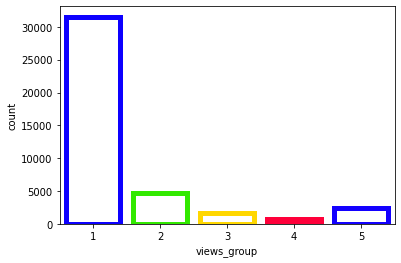

In [ ]:
# Creating countplot to visualize the group distibution and defining a "view" column for that
feature_counter(data ,10000000 , 'views' , 'views_group')
data.drop(['views'],axis=1, inplace=True)
my_countplot('views_group')

**Likes**

In [ ]:
# finding the max and min number of likes 
print('The minimum number of views:', data['likes'].min())
print('The maximum number of views:', data['likes'].max())

The minimum number of views: 0
The maximum number of views: 5613827


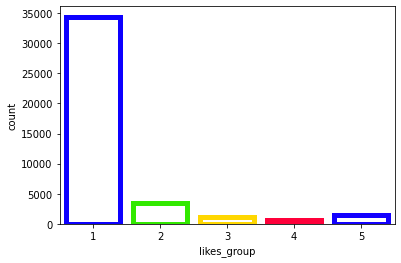

In [ ]:
# Creating countplot to visualize the group distibution and defining a "likes" column for that
feature_counter(data ,500000 , 'likes' , 'likes_group')
data.drop(['likes'],axis=1, inplace=True)
my_countplot('likes_group')

**Dislikes**

In [ ]:
# finding the max and min number of likes 
print('The minimum number of views:', data['dislikes'].min())
print('The maximum number of views:', data['dislikes'].max())

The minimum number of views: 0
The maximum number of views: 1674420


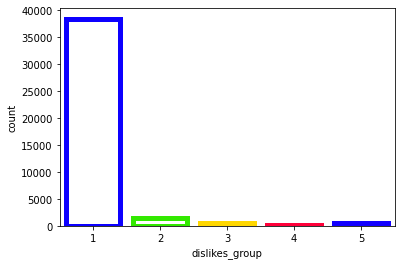

In [ ]:
# Creating countplot to visualize the group distibution and defining a "dislikes" column for that
feature_counter(data ,50000 , 'dislikes' , 'dislikes_group')
data.drop(['dislikes'],axis=1, inplace=True)
my_countplot('dislikes_group')

**Comments**

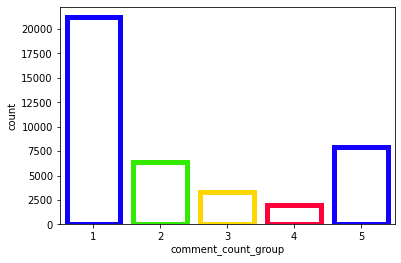

In [ ]:
# Creating countplot to visualize the group distibution and defining a "comment_count" column for that
feature_counter(data ,10000 , 'comment_count' , 'comment_count_group')
data.drop(['comment_count'],axis=1, inplace=True)
my_countplot('comment_count_group')

**Thumbnail Link**

In [ ]:
# dropping thumbnail link as no information is retreived
data.drop(['thumbnail_link'],axis=1, inplace=True)

**Comments disabled**

In [ ]:
# label encoding "comments_disabled" column
my_label_encoding('comments_disabled','comments_disabled_enc')

**Ratings Disabled**

In [ ]:
# label encoding "ratings disabled" column
my_label_encoding('ratings_disabled','ratings_disabled_enc')

**Video Error or Removed**

In [ ]:
# label encoding "video error or removed" column
my_label_encoding('video_error_or_removed','video_error_or_removed_enc')

**Description**

In [ ]:
# label encoding "description" column
my_label_encoding('description','description_enc')

**Defining Datasets**

In [ ]:
# defining input matrix and labels
X = data.drop(['category_id'], axis=1, inplace=False)
y = data['category_id']

# splitting datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, shuffle =True, stratify=y)

# outputting shapes of each
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (32759, 36)
X_test shape is  (8190, 36)
y_train shape is  (32759,)
y_test shape is  (8190,)


**Evaluating performances on Model (Only the optimal parameters are chosen and evaluated here)**

In [ ]:
# training and evaluating on gradient boosting classifier
GBCModel = GradientBoostingClassifier(n_estimators=100,max_depth=25,random_state=33) 
GBCModel.fit(X_train, y_train)
print('GBCModel Test Score: ' , GBCModel.score(X_test, y_test))

GBCModel Test Score:  0.9864468864468865


In [ ]:
# training and evaluating on histogram gradient boosting classifier
HGBCModel = HistGradientBoostingClassifier(max_leaf_nodes=100,max_depth=25,random_state=33) 
HGBCModel.fit(X_train, y_train)
print('HGBCModel Test Score: ' , HGBCModel.score(X_test, y_test))

HGBCModel Test Score:  0.9871794871794872


In [ ]:
# training and evaluating on xgboost classifier
X_train['Month'] = X_train['Month'].astype(str).astype(int)
X_train['Day'] = X_train['Day'].astype(str).astype(int)
X_test['Month'] = X_test['Month'].astype(str).astype(int)
X_test['Day'] = X_test['Day'].astype(str).astype(int)
XGBModel = XGBClassifier(n_estimators=100,max_depth=20,random_state=33) 
XGBModel.fit(X_train, y_train)
print('XGBModel Test Score: ' , XGBModel.score(X_test, y_test))

XGBModel Test Score:  0.9896214896214897


In [ ]:
# training and evaluating on decision tree classifier

DecisionTreeClassifierModel = DecisionTreeClassifier(criterion='entropy',max_depth=30,random_state=33) #criterion can be entropy
DecisionTreeClassifierModel.fit(X_train, y_train)

#Calculating Details
print('DecisionTreeClassifierModel Train Score is : ' , DecisionTreeClassifierModel.score(X_train, y_train))
print('DecisionTreeClassifierModel Test Score is : ' , DecisionTreeClassifierModel.score(X_test, y_test))

DecisionTreeClassifierModel Train Score is :  1.0
DecisionTreeClassifierModel Test Score is :  0.9826617826617826


In [ ]:
# training and evaluating on random forest classifier

RFCModel = RandomForestClassifier(max_leaf_nodes=2000, max_depth=50, random_state=33)
RFCModel.fit(X_train, y_train)
print('RandomForestClassifierModel Train Score is : ' , RFCModel.score(X_train, y_train))
print('RandomForestClassifierModel Test Score is : ' , RFCModel.score(X_test, y_test))

RandomForestClassifierModel Train Score is :  0.9859885832900882
RandomForestClassifierModel Test Score is :  0.9611721611721612


**Comparing Predictions and Actual values using our best model**

In [ ]:
print('The first 5 category prediction: ', XGBModel.predict(X_test)[:5])
print('The first 5 categories: ', list(y_test[:5]))

The first 5 category prediction:  [24 24 27 10 22]
The first 5 categories:  [24, 24, 27, 10, 22]


**Final Dataframe**

In [ ]:
# dataframe used for preprocessing
data

,category_id,video_id_enc,Year,Month,Day,word 1,word 2,word 3,word 4,word 5,word 6,word 7,word 8,word 9,word 10,word 11,word 12,word 13,word 14,word 15,word 16,word 17,word 18,word 19,word 20,channel_title_enc,Publish Quarter,publish_time_enc,tags_enc,views_group,likes_group,dislikes_group,comment_count_group,comments_disabled_enc,ratings_disabled_enc,video_error_or_removed_enc,description_enc
0,22,376,0,11,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,335,3,317,1914,1,1,1,5,0,0,0,4488
1,24,256,0,11,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1008,2,286,4340,2,1,1,5,0,0,0,4033
2,23,696,0,11,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1499,4,270,5047,2,2,1,5,0,0,0,6033
3,24,5377,0,11,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,706,2,290,5143,1,1,1,2,0,0,0,5847
4,24,4067,0,11,14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2147,4,268,5210,2,2,1,5,0,0,0,2360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,15,1257,1,06,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,3,5928,2627,1,1,1,2,0,0,0,5202
40945,22,267,1,06,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2198,1,5919,2612,1,1,1,2,0,0,0,6901
40946,24,1411,1,06,14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,237,3,5934,1078,1,1,1,2,0,0,0,2350
40947,1,5222,1,06,14,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,778,3,5913,311,3,2,1,5,0,0,0,2254
